# Cultural Omnivorousness as a Result of Local Genre Network Structures

This is the Jupyter Notebook script accompanying the assignment submission of the above titled work for the Online Social Networks class by candidate.

In [1]:
import numpy as np
import pandas as pd
from os import sep
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure, text
import seaborn as sns
import cairocffi
import itertools
import string
import ast
import networkx as nx
from networkx.algorithms import bipartite
from scipy import spatial
from scipy import stats
from itertools import chain
from os import sep
import konectipy.konectipy as kpy

## Spotify Network Creation

First, I will read in the data collected via the Spotify API, which contains over 38,000 artists and their assigned genre tags. Next, I will create a series of all genre tags and their occurrance, which forms the basis for the Spotify Network nodes. The Spotify Network is a network of genres, where genres are connected if both are attached to the same artist.

In [35]:
# Reading in artists data and removing artists without any genres tagged as well as extranneous columns
artists = pd.read_csv(f"data{sep}artist_data_final.csv")
artists = artists.loc[artists['genres'] != '[]']
artists = artists.reset_index(drop=True)
artists = artists.drop(['Unnamed: 0','id','uri'],axis=1)

In [ ]:
# Creating a list for each genre tag per artist and adding as column in dataframe
genre_list = []
for i in range(len(artists)):
    l = artists['genres'][i]
    genre_list.append(ast.literal_eval(l))
    
artists['genres'] = genre_list

In [ ]:
# Exploding the artist dataframe to create genre series and list
artists_exp = artists.explode('genres')
artists_exp['genres'] = artists_exp['genres'].str.lower()

art_ser = artists_exp['genres'].value_counts()
art_ser = art_ser[art_ser >= 40] # setting minimum amount of mentions per tag to be considered
art_list = art_ser.index.to_list() # listing all genres in the network above 40 mentions

In [ ]:
# Creating network nodes and saving them
nodes = art_ser.to_dict()
np.save(f'data{sep}spotify_nodes.npy', nodes) 

Next, I create a co-occurrance matrix based on the genres attached to artists listed on Spotify. A genre co-occurs with another if both are attached to the same artist. This will serve as a basis for creating the Spotify Network edges.

In [ ]:
# Creating co-occurence matrix for Spotify genre network
correlation_matrix = {}
for i in art_list:
    correlation_matrix['%s' % i] = []
    
for i in art_list:
    for j in artists['genres']:
        if i in j:
            correlation_matrix[i].append(1)
        else:
            correlation_matrix[i].append(0)
            
corr_df = pd.DataFrame(correlation_matrix)

In [ ]:
# Creating network edges
g1_list = []
g2_list = []
cos_dis_list = []
g_list = []

for i in corr_df.columns:
    
    for j in corr_df.columns:
        
        g1 = corr_df[i].to_list()
        g1_list.append(i)
        
        g2 = corr_df[j].to_list()
        g2_list.append(j)
        
        g_list.append([i,j])
        
        if i != j:
            cos_dis = 1 - spatial.distance.cosine(g1, g2)
            cos_dis_list.append(cos_dis)
            
        else:
            cos_dis_list.append(np.nan)
            
edges = pd.DataFrame({'genre_1':g1_list,
                     'genre_2':g2_list,
                     'cosine_distance':cos_dis_list,
                     'genre_list':g_list})
edges = edges.dropna()

for i in edges['genre_list']:
    i = i.sort()
    
g = edges['genre_list'].to_list()
g_string = []
for i in range(len(edges)):
    g_1 = g[i][0]
    g_2 = g[i][1]
    g_str = g_1 + g_2
    g_string.append(g_str)
edges['genre_string'] = g_string
edges = edges.drop_duplicates(subset='genre_string')
edges = edges.drop(['genre_list', 'genre_string'], axis=1)
edges = edges[edges['cosine_distance'] != 0]

g1 = list(set(edges['genre_1'].to_list()))
g2 = list(set(edges['genre_2'].to_list()))
g = g1 + g2
g = list(set(g))

nodes_del = []
for i in nodes.keys():
    if i not in g:
        nodes_del.append(i)

edges.to_csv(f'data{sep}spotify_edges.csv',index=False)

# Last.fm One-Mode Network Creation

In this section, I create the Last.fm Network. First, I read in user-generated data collected via the Last.fm API, which contains usernames and genre tags which users attach to their own library as well as overall playcount per user. The process is similar to the Spotify Network node and egde creation. The Last.fm Network is a network of genre connections, where a genre is connected with another if both have been tagged by the same user.

Before creating the nodes, however, I will need to filter the genre tags attached to a users library. This includes removing special characters, spaces as well as merging similar (but differently spelled) tags and deleting tags without meaning.

In [ ]:
# Reading in the data
data = pd.read_csv(f'data{sep}data.csv')
data = data.drop_duplicates(subset=['user']).reset_index().drop('index',axis=1)

tag_list = []
tag_count_list = []

for i in range(len(data)):

    try:
        tags = list((ast.literal_eval(data['tags'][i])).keys())
        tag_list.append(tags)
    except:
        tag_list.append(np.nan)
        
    try:
        tag_count = list((ast.literal_eval(data['tags'][i])).values())
        tag_count_list.append(tag_count)
    except:
        tag_count_list.append(np.nan)

data['tag'] = tag_list
data['tag_count'] = tag_count_list

In [ ]:
# Creating clean genre tag dataframe from data
tags_df = data
tags_df = tags_df[tags_df['tags'] != '{}']
tags_df = tags_df.apply(lambda x: x.explode() if x.name in ['artist_names', 'artist_playcount','tag','tag_count'] else x).reset_index(drop=True)
tags_df['tag'] = tags_df['tag'].str.lower()
tags_df['tag'] = tags_df['tag'].str.strip()

tag_no_space = []
for i in tags_df['tag']:
    string = str(i).replace(" ", "")
    string = string.replace("-","")
    tag_no_space.append(string)
tags_df['tags_no_space'] = tag_no_space
tags_df = tags_df.drop('tag',axis=1)
tags_df = tags_df.rename(columns={"tags_no_space":"tag"})

In [ ]:
# Replacing genres that a written varieties of each other
replace_list = [['british','uk','english'],['jazz','jazzy'],
                ['dumnbass','dnb'],['80s',"80's"],['funk','funky'],
                ['rocknroll','rockandroll',"rock'n'roll"],
                ['r&b','rnb','rhythmandblues'],['worldmusic','world'],
                ['germany','deutsch'],['electronica','electronic']]

for i in replace_list:
    tags_df = tags_df.replace(i[1:],i[0])

In [ ]:
# Deleting genre tags that do not have a clear genre associated with it
last_nodes_del = ['seenlive','beautiful','awesome',
                  'epic','chill','love','sexy','sad','melancholic',
                  'amazing','live','remix','melancholy','albumsiown',
                  'female','under2000listeners','easylistening',
                  'political','bass','favorites','happy','crossover',
                  'dreamy','fun','covers','cover','masterpiece',
                  'catchy','funny','cool','relaxing','genius',
                  'summer','gay','videogamemusic','party','newyork',
                  'ethnic','relax','cute','club','favorite',
                  'emotional','fuckingawesome','legend','sex','sweet',
                  'perfect','guiltypleasure','smooth','underrated',
                  'favourite','weird','<3','shit','2013','lovely',
                  'god','game','favoritealbums','favouritealbums',
                  'riotgrrrl','urban','great','2009','videogame',
                  'bestsongever','disney','london','hot',
                  'nan','2011','chicago','trippy','traditional','nostalgia',
                  '2010','2008','best','feelgood','2012','solo','dark','seattle',
                  'slow','favourites','death','trash']

tags_df = tags_df[~tags_df['tag'].isin(last_nodes_del)]

In [ ]:
# Creating genre tag list and ranked series
tag_ser = tags_df['tag'].value_counts()
tag_ser = tag_ser[tag_ser >= 135] # setting minimum amount of mentions to be consider
tag_list = tag_ser.index.to_list()

nodes = tag_ser.to_dict()
np.save(f'data{sep}nodes.npy', nodes)

Next, I create a co-occurrence matrix again, which serves as the basis for the Last.fm network edges.

In [ ]:
# Aggregating genre tags to build correlation matrix
tags_agg_df = (tags_df.groupby(['user',
                                'country',
                                'registered',
                                'tags',
                                'playcount'])
              .agg({'tag': lambda x: x.tolist(),'tag_count': lambda x: x.tolist()})
              .reset_index())

In [ ]:
# Creating correlation matrix
correlation_matrix = {}
for i in tag_list:
    correlation_matrix['%s' % i] = []
    
for i in tag_list:
    for j in tags_agg_df['tag']:
        if i in j:
            correlation_matrix[i].append(1)
        else:
            correlation_matrix[i].append(0)
            
corr_df = pd.DataFrame(correlation_matrix)

In [ ]:
# Creating and saving edges
g1_list = []
g2_list = []
cos_dis_list = []
g_list = []

for i in corr_df.columns:
    
    for j in corr_df.columns:
        
        g1 = corr_df[i].to_list()
        g1_list.append(i)
        
        g2 = corr_df[j].to_list()
        g2_list.append(j)
        
        g_list.append([i,j])
        
        if i != j:
            cos_dis = 1 - spatial.distance.cosine(g1, g2)
            cos_dis_list.append(cos_dis)
            
        else:
            cos_dis_list.append(np.nan)
            
edges = pd.DataFrame({'genre_1':g1_list,
                     'genre_2':g2_list,
                     'cosine_distance':cos_dis_list,
                     'genre_list':g_list})
edges = edges.dropna()

for i in edges['genre_list']:
    i = i.sort()
    
g = edges['genre_list'].to_list()
g_string = []
for i in range(len(edges)):
    g_1 = g[i][0]
    g_2 = g[i][1]
    g_str = g_1 + g_2
    g_string.append(g_str)
edges['genre_string'] = g_string
edges = edges.drop_duplicates(subset='genre_string')
edges = edges.drop(['genre_list', 'genre_string'], axis=1)
edges = edges[edges['cosine_distance'] != 0]

edges.to_csv(f'data{sep}edges.csv',index=False)

# Last.fm Two-Mode Network Creation

In this section, I create a bipartite network for the Last.fm data. The bipartite network consists of users on the one side and genre tags on the other. I use the above dataframes to parse in the nodes and edges into the network.

In [ ]:
# node creation
genre_nodes = list(tags_df['tag'].unique())
user_nodes = list(tags_df['user'].unique())

# edge creation
edge_l1 = list(tags_df['user'])
edge_l2 = list(tags_df['tag'])
edges = list(zip(edge_l1, edge_l2))

In [ ]:
# this is to delete any user that does not have a tag mentioned >135x
full_user = list(data['user'].unique())
restricted_user = user_nodes

deleted_user = [x for x in full_user if x not in restricted_user]
data_cleaned = data[~data['user'].isin(deleted_user)].reset_index()
data_cleaned.to_csv(f'data{sep}data_cleaned.csv')

In [ ]:
bipartite_G = nx.Graph()

## Logic to add nodes and edges to graph with their metadata
for r, d in tags_df.iterrows():
    pid = '{0}'.format(d['user'])  # pid = "Person I.D."
    cid = '{0}'.format(d['tag'])  # cid = "Crime I.D."
    bipartite_G.add_node(pid, bipartite='user')
    bipartite_G.add_node(cid, bipartite='genre')
    bipartite_G.add_edge(pid, cid, role=d['tag_count']) # playcount

In [ ]:
user_nodes = list(set(n for n,d in bipartite_G.nodes(data=True) if d['bipartite']=='user'))
genre_nodes = list(set(n for n,d in bipartite_G.nodes(data=True) if d['bipartite']=='genre'))

In [ ]:
nx.write_gexf(bipartite_G, f"data{sep}bipartite_network.gexf")

# Two-Mode Analysis

This section creates several metrics derived from the bipartite Last.fm network for analysis in the written paper. For ease of running this script, I read in the above network first.

In [ ]:
bipartite_G = nx.read_gexf(f'data{sep}bipartite_network.gexf')

In [ ]:
degGenre, degUser = bipartite.degrees(bipartite_G, user_nodes)

user_degree = dict(degUser)
genre_degree = dict(degGenre)

In [ ]:
user_degree_dist = {}
for i in user_degree.values():
    if i in user_degree_dist.keys():
        user_degree_dist[i] += 1
    else:
        user_degree_dist[i] = 1

user_degree_dist = dict(sorted(user_degree_dist.items()))
    
genre_degree_dist = {}
for i in genre_degree.values():
    if i in genre_degree_dist.keys():
        genre_degree_dist[i] += 1
    else:
        genre_degree_dist[i] = 1
        
genre_degree_dist = dict(sorted(genre_degree_dist.items()))

In [ ]:
def append_value(dict_obj, key, value):
    if key in dict_obj:
        if not isinstance(dict_obj[key], list):
            dict_obj[key] = [dict_obj[key]]
        dict_obj[key].append(value)
    else:
        dict_obj[key] = value

### Average popularity/omnivorousness of cultural choices

In [ ]:
temp = {}
avg_pop_choice = {}
        
for num,i in enumerate(user_nodes):
    genre_list = list(tags_df[tags_df['user'] == i]['tag'])
    for j in genre_nodes:
        if j in genre_list:
            degree = genre_degree[j]
            append_value(temp,i,degree)  
    if num % 500 == 0:
        print(num/len(user_nodes))

for key,val in temp.items():
    try:
        s = sum(val)
        l = len(val)
        avg_pop_choice[key] = s/l
    except:
        s = val
        avg_pop_choice[key] = s

In [ ]:
temp = {}
avg_omni_genre = {}

for num,i in enumerate(user_nodes):
    genre_list = list(tags_df[tags_df['user'] == i]['tag'])
    for j in genre_nodes:
        if j in genre_list:
            degree = user_degree[i]
            append_value(temp,j,degree)  
    if num % 500 == 0:
        print(num/len(user_nodes))

for key,val in temp.items():
    s = sum(val)
    l = len(val)
    avg_omni_genre[key] = s/l

### Average audience omnivorousness/popularity bias

In [ ]:
temp = {}
avg_aud_omni = {}
        
for num,i in enumerate(user_nodes):
    genre_list = list(tags_df[tags_df['user'] == i]['tag'])
    for j in genre_nodes:
        if j in genre_list:
            degree = avg_omni_genre[j]
            append_value(temp,i,degree)  
    if num % 500 == 0:
        print(num/len(user_nodes))

for key,val in temp.items():
    try:
        s = sum(val)
        l = len(val)
        avg_aud_omni[key] = s/l
    except:
        s = val
        avg_aud_omni[key] = s

In [ ]:
temp = {}
avg_pop_bias = {}

for num,i in enumerate(user_nodes):
    genre_list = list(tags_df[tags_df['user'] == i]['tag'])
    for j in genre_nodes:
        if j in genre_list:
            degree = avg_pop_choice[i]
            append_value(temp,j,degree)  
    if num % 500 == 0:
        print(num/len(user_nodes))

for key,val in temp.items():
    s = sum(val)
    l = len(val)
    avg_pop_bias[key] = s/l

### Average audience playcount

In [ ]:
temp = {}
avg_genre_playcount = {}

for num,i in enumerate(list(data_cleaned['user'])):
    genre_list = list(tags_df[tags_df['user'] == i]['tag'])
    for j in genre_nodes:
        if j in genre_list:
            playcount = data_cleaned['playcount'][num]
            append_value(temp,j,playcount)  
    if num % 500 == 0:
        print(num/len(user_nodes))

for key,val in temp.items():
    s = sum(val)
    l = len(val)
    avg_genre_playcount[key] = s/l

### Creating dataframe from above measures

Here, I summarise the metrics calculated above into a centralised dataframe for use below.

In [ ]:
genre_overview = pd.DataFrame([genre_degree, avg_omni_genre, avg_pop_bias, avg_genre_playcount]).T
genre_overview.columns = ['genre_degree','avg_omni_degree','avg_pop_bias', 'avg_genre_playcount']
genre_overview = genre_overview.dropna()
genre_overview.to_csv(f'data{sep}genre_overview.csv')

genre_overview = pd.read_csv(f'data{sep}genre_overview.csv')
genre_overview = genre_overview.rename({'Unnamed: 0':'genre'},axis=1)
genre_overview = genre_overview.set_index('genre')
genre_overview = genre_overview.sort_values(by=['genre_degree'],ascending=False)

In [ ]:
user_overview = pd.DataFrame([user_degree, avg_pop_choice, avg_aud_omni]).T
user_overview.columns = ['user_degree', 'avg_pop_choice', 'avg_aud_omni']
user_overview = user_overview.dropna()
user_overview.to_csv(f'data{sep}user_overview.csv')

user_overview = pd.read_csv(f'data{sep}user_overview.csv')

## Generating random network

Here, I generate a random network to test for meaningful deviations from random relationships between the above calcualted metrics.

In [ ]:
def permute_network(G, Q):
    H = G.copy()
    nx.double_edge_swap(H, nswap=Q*len( G.edges() ), max_tries=1e75)
    return H

In [ ]:
random_G = permute_network(bipartite_G, 100)
nx.write_gexf(random_G, f"data{sep}random_network.gexf")
random_G = nx.read_gexf(f"data{sep}random_network.gexf")

In [ ]:
r_user_nodes = list(set(n for n,d in random_G.nodes(data=True) if d['bipartite']=='user'))
r_genre_nodes = list(set(n for n,d in random_G.nodes(data=True) if d['bipartite']=='genre'))

rdegGenre, rdegUser = bipartite.degrees(random_G, r_user_nodes)

r_user_degree = dict(rdegUser)
r_genre_degree = dict(rdegGenre)

### Creating above metrics for random network

In [ ]:
r_user_degree_dist = {}
for i in r_user_degree.values():
    if i in r_user_degree_dist.keys():
        r_user_degree_dist[i] += 1
    else:
        r_user_degree_dist[i] = 1

r_user_degree_dist = dict(sorted(r_user_degree_dist.items()))
    
r_genre_degree_dist = {}
for i in r_genre_degree.values():
    if i in r_genre_degree_dist.keys():
        r_genre_degree_dist[i] += 1
    else:
        r_genre_degree_dist[i] = 1
        
r_genre_degree_dist = dict(sorted(r_genre_degree_dist.items()))

In [ ]:
r_user_genre_dic = {}
for i in r_user_nodes:
    temp_list = []
    
    genres = list(random_G.edges([i]))
    length = len(list(random_G.edges([i])))
    
    for j in range(length):
        temp_list.append(genres[j][1])
    
    r_user_genre_dic[i] = temp_list

### Average popularity/omnivorousness of cultural choices

In [ ]:
temp = {}
r_avg_pop_choice = {}
        
for num,i in enumerate(r_user_nodes):
    r_genre_list = r_user_genre_dic[i]
    for j in r_genre_nodes:
        if j in r_genre_list:
            degree = r_genre_degree[j]
            append_value(temp,i,degree)  
    if num % 500 == 0:
        print(num/len(user_nodes))

for key,val in temp.items():
    try:
        s = sum(val)
        l = len(val)
        r_avg_pop_choice[key] = s/l
    except:
        s = val
        r_avg_pop_choice[key] = s

In [ ]:
temp = {}
r_avg_omni_genre = {}

for num,i in enumerate(r_user_nodes):
    r_genre_list = r_user_genre_dic[i]
    for j in r_genre_nodes:
        if j in r_genre_list:
            degree = r_user_degree[i]
            append_value(temp,j,degree)  
    if num % 500 == 0:
        print(num/len(user_nodes))

for key,val in temp.items():
    s = sum(val)
    l = len(val)
    r_avg_omni_genre[key] = s/l

### Average audience omnivorousness/popularity bias

In [ ]:
temp = {}
r_avg_aud_omni = {}
        
for num,i in enumerate(r_user_nodes):
    r_genre_list = r_user_genre_dic[i]
    for j in r_genre_nodes:
        if j in r_genre_list:
            degree = r_avg_omni_genre[j]
            append_value(temp,i,degree)  
    if num % 500 == 0:
        print(num/len(user_nodes))

for key,val in temp.items():
    try:
        s = sum(val)
        l = len(val)
        r_avg_aud_omni[key] = s/l
    except:
        s = val
        r_avg_aud_omni[key] = s

In [ ]:
temp = {}
r_avg_pop_bias = {}

for num,i in enumerate(r_user_nodes):
    r_genre_list = r_user_genre_dic[i]
    for j in r_genre_nodes:
        if j in r_genre_list:
            degree = r_avg_pop_choice[i]
            append_value(temp,j,degree)  
    if num % 500 == 0:
        print(num/len(user_nodes))

for key,val in temp.items():
    s = sum(val)
    l = len(val)
    r_avg_pop_bias[key] = s/l

### Average audience playcount

In [ ]:
user_playcount_dict = {}
for i in range(len(data)):
    if data['user'][i] in r_user_nodes:
        user_playcount_dict[data['user'][i]] = data['playcount'][i]

In [ ]:
temp = {}
r_avg_genre_playcount = {}

for num,i in enumerate(r_user_nodes):
    r_genre_list = r_user_genre_dic[i]
    for j in r_genre_nodes:
        if j in r_genre_list:
            playcount = user_playcount_dict[i]
            append_value(temp,j,playcount)  
    if num % 500 == 0:
        print(num/len(r_user_nodes))

for key,val in temp.items():
    s = sum(val)
    l = len(val)
    r_avg_genre_playcount[key] = s/l

### Creating dataframe from above measures

In [ ]:
r_genre_overview = pd.DataFrame([r_genre_degree, r_avg_omni_genre, r_avg_pop_bias, r_avg_genre_playcount]).T
r_genre_overview.columns = ['r_genre_degree','r_avg_omni_degree','r_avg_pop_bias' ,'r_avg_genre_playcount']
r_genre_overview = r_genre_overview.dropna()
r_genre_overview.to_csv(f'data{sep}r_genre_overview.csv')

In [ ]:
r_user_overview = pd.DataFrame([r_user_degree, r_avg_pop_choice, r_avg_aud_omni]).T
r_user_overview.columns = ['r_user_degree', 'r_avg_pop_choice', 'r_avg_aud_omni']
r_user_overview = r_user_overview.dropna()
r_user_overview.to_csv(f'data{sep}r_user_overview.csv')

## Plotting relationships between above measures

In this section, I plot the relationship between the above calculated metrics and add a line for the random graph created above. I start by calculating the random relationship between the above metrics and extract the line to be plotted in the user-generated graphs.

In [2]:
# reading in the dataframes
r_genre_overview = pd.read_csv(f'data{sep}r_genre_overview.csv',index_col=0)
r_user_overview = pd.read_csv(f'data{sep}r_user_overview.csv',index_col=0)
r_big_genre = r_genre_overview[r_genre_overview['r_genre_degree'] > 4250]

genre_overview = pd.read_csv(f'data{sep}genre_overview.csv',index_col=0)
user_overview = pd.read_csv(f'data{sep}user_overview.csv',index_col=0)
big_genre = genre_overview[genre_overview['genre_degree'] > 4250]

last_nodes = np.load(f'data{sep}nodes.npy',allow_pickle=True).tolist()
last_edges = pd.read_csv(f'data{sep}edges.csv')

spotify_edges = pd.read_csv(f'data{sep}spotify_edges.csv')

### Plotting random graphs

The slope coefficient is: 826.4417852034125, with a p-value of 0.02714076283734627


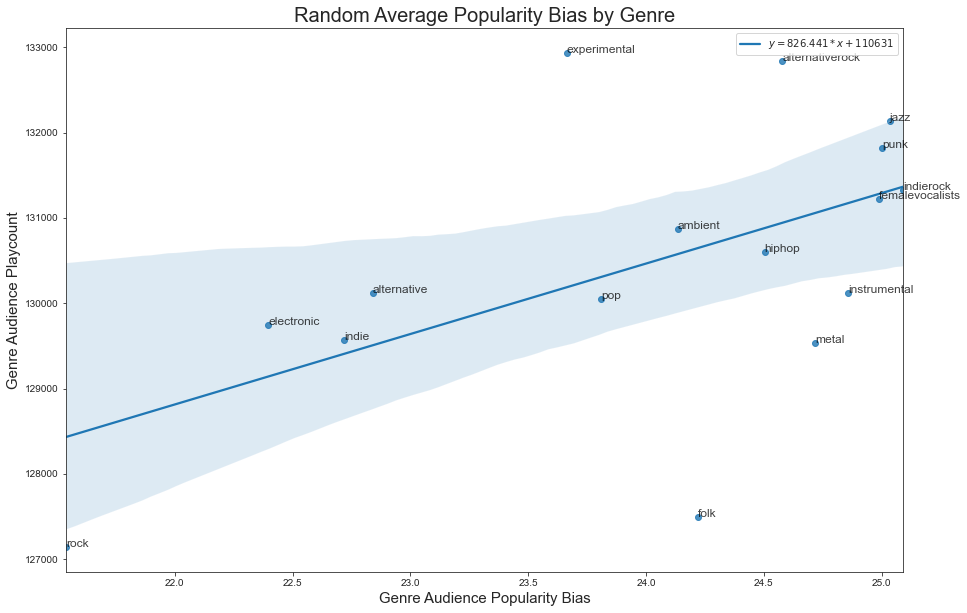

In [3]:
# plotting random relationship between average genre audience omnivorousness against average genre audience playcount
plt.figure(figsize=(15,10))
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 8})
slope, intercept, r_value, pv, se = stats.linregress(r_big_genre['r_avg_omni_degree'], r_big_genre['r_avg_genre_playcount'])
_ = sns.regplot(data=r_big_genre,x='r_avg_omni_degree',y='r_avg_genre_playcount',line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
_.tick_params(labelsize=10)
plt.title('Random Average Popularity Bias by Genre',fontsize=20) #title
plt.xlabel('Genre Audience Popularity Bias',fontsize=15) #x label
plt.ylabel('Genre Audience Playcount',fontsize=15) #y label
plt.legend()

print("The slope coefficient is: {}, with a p-value of {}".format(slope,pv))

for i in range(r_big_genre.shape[0]):
    plt.text(x=r_big_genre.r_avg_omni_degree[i],y=r_big_genre.r_avg_genre_playcount[i],s=r_big_genre.index[i],
             fontdict=dict(color='black',size=12, alpha = 0.75))

plt.show()

The slope coefficient is: -3.831708122106295, with a p-value of 0.024680209623123995


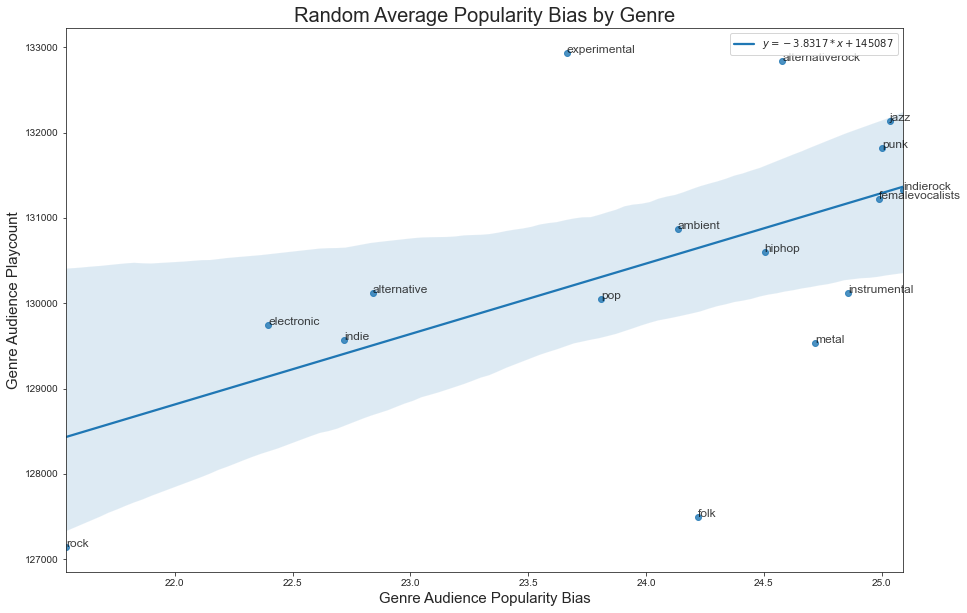

In [4]:
# plotting random relationship between average genre audience popularity bias against average genre audience playcount
plt.figure(figsize=(15,10))
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 8})
slope, intercept, r_value, pv, se = stats.linregress(r_big_genre['r_avg_pop_bias'], r_big_genre['r_avg_genre_playcount'])
_ = sns.regplot(data=r_big_genre,x='r_avg_omni_degree',y='r_avg_genre_playcount',line_kws={'label':'$y=%3.7s*x+%3.7s$'%(slope, intercept)})
_.tick_params(labelsize=10)
plt.title('Random Average Popularity Bias by Genre',fontsize=20) #title
plt.xlabel('Genre Audience Popularity Bias',fontsize=15) #x label
plt.ylabel('Genre Audience Playcount',fontsize=15) #y label
plt.legend()

print("The slope coefficient is: {}, with a p-value of {}".format(slope,pv))

for i in range(r_big_genre.shape[0]):
    plt.text(x=r_big_genre.r_avg_omni_degree[i],y=r_big_genre.r_avg_genre_playcount[i],s=r_big_genre.index[i],
             fontdict=dict(color='black',size=12, alpha = 0.75))

plt.show()

### Plotting user-generated graphs

Slope: 505.85665269410237, p-value: 0.22278521816270458


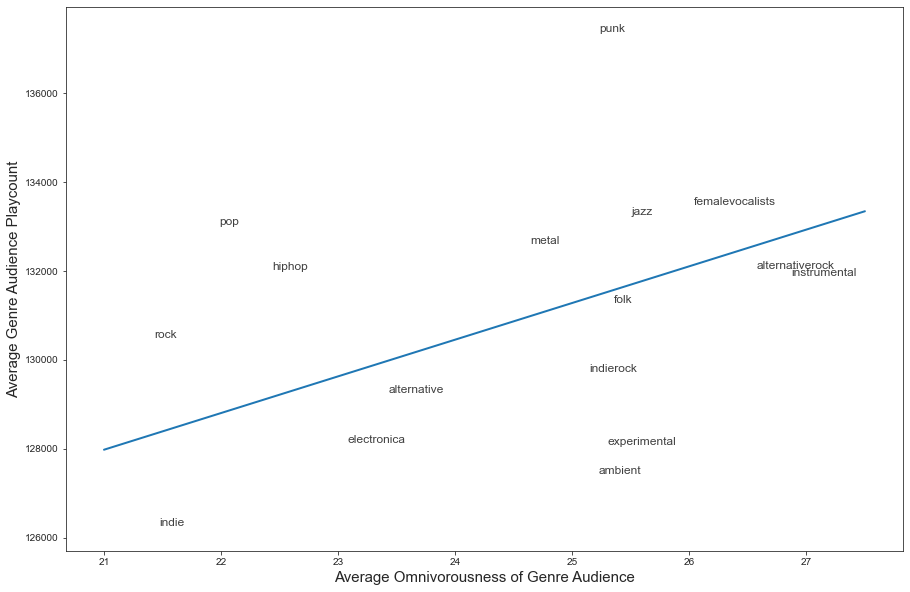

In [5]:
# Plotting average genre audience omnivorousness agains average genre audience playcount

plt.figure(figsize=(15,10))
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 8})
slope, intercept, r_value, pv, se = stats.linregress(big_genre['avg_omni_degree'], big_genre['avg_genre_playcount'])
ax = sns.scatterplot(data=big_genre,x='avg_omni_degree',y='avg_genre_playcount', alpha=0)
plt.xlabel('Average Omnivorousness of Genre Audience',fontsize=15) #x label
plt.ylabel('Average Genre Audience Playcount',fontsize=15) #y label

# plotting random line
plt.plot([21, 27.5], [127977.2, 133346.5], linewidth=2)

print(f"Slope: {slope}, p-value: {pv}")

for i in range(big_genre.shape[0]):
    plt.text(x=big_genre.avg_omni_degree[i],y=big_genre.avg_genre_playcount[i],s=big_genre.index[i],
             fontdict=dict(color='black',size=12, alpha = 0.75))

plt.savefig('avg_play_omni_genre.jpg',bbox_inches='tight')
plt.show()

Slope: -4.209434903628635, p-value: 0.08438239933444841


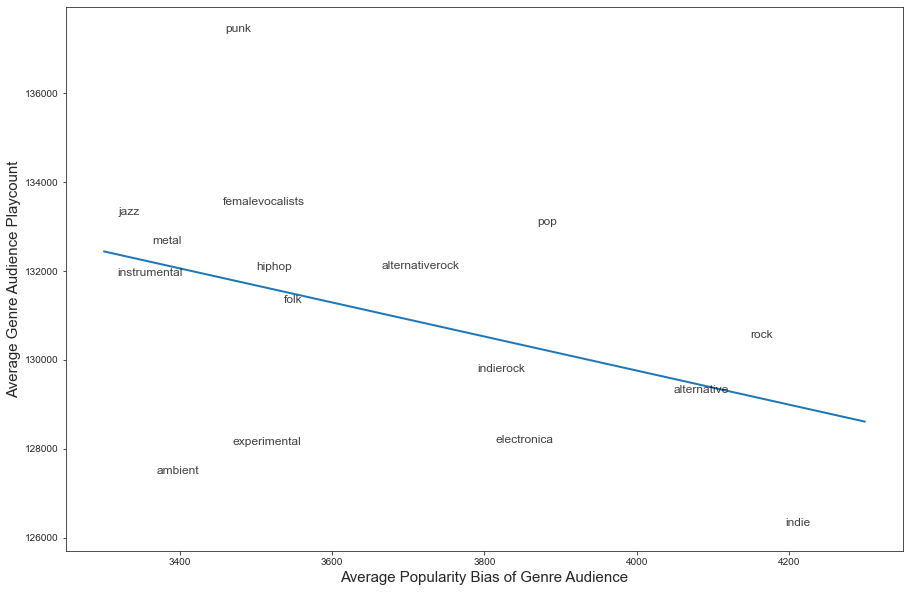

In [6]:
# Plotting average genre audience popularity bias against average genre audience playcount

plt.figure(figsize=(15,10))
sns.set_style("ticks", {"xtick.major.size": 2, "ytick.major.size": 8})
slope, intercept, r_value, pv, se = stats.linregress(big_genre['avg_pop_bias'], big_genre['avg_genre_playcount'])
ax = sns.scatterplot(data=big_genre,x='avg_pop_bias',y='avg_genre_playcount', alpha=0)
plt.xlabel('Average Popularity Bias of Genre Audience',fontsize=15) #x label
plt.ylabel('Average Genre Audience Playcount',fontsize=15) #y label

# plotting random line
plt.plot([3300, 4300], [132442, 128610], linewidth=2)

print(f"Slope: {slope}, p-value: {pv}")

for i in range(big_genre.shape[0]):
    plt.text(x=big_genre.avg_pop_bias[i],y=big_genre.avg_genre_playcount[i],s=big_genre.index[i],
             fontdict=dict(color='black',size=12, alpha = 0.75))

plt.savefig('avg_play_pop_genre.jpg',bbox_inches='tight')
plt.show()

# Comparative Analysis

In this section I construct the last.fm and Spotify one-mode network. I create whole-network descriptive metrics and local network circular bar plots as per the paper.

In [7]:
# Creating last.fm network

last = nx.Graph()

for i in range(len(last_edges)):
    g1 = last_edges.iloc[i,:].to_list()[0]
    g2 = last_edges.iloc[i,:].to_list()[1]
    weight = last_edges.iloc[i,:].to_list()[2]
    last.add_edge(g1,g2,weight=weight)
    
threshold = 0.1125

# filter out all edges above threshold and grab id's
long_edges = list(filter(lambda e: e[2] < threshold, (e for e in last.edges.data('weight'))))
le_ids = list(e[:2] for e in long_edges)
last.remove_edges_from(le_ids)

edges_net = last.edges()

tmp_components = sorted(nx.connected_components(last), key=len)
small_components = []
for i in tmp_components:
    l = len(i)
    if l == 1:
        small_components.append(list(i)[0])
last.remove_nodes_from(small_components)

nx.write_gexf(last, f"data{sep}last.gexf")

In [8]:
spotify = nx.Graph()

for i in range(len(spotify_edges)):
    g1 = spotify_edges.iloc[i,:].to_list()[0]
    g2 = spotify_edges.iloc[i,:].to_list()[1]
    weight = spotify_edges.iloc[i,:].to_list()[2]
    spotify.add_edge(g1,g2,weight=weight)
    
threshold = 0

# filter out all edges above threshold and grab id's
long_edges = list(filter(lambda e: e[2] < threshold, (e for e in spotify.edges.data('weight'))))
le_ids = list(e[:2] for e in long_edges)
spotify.remove_edges_from(le_ids)

edges_net = spotify.edges()

tmp_components = sorted(nx.connected_components(spotify), key=len)
small_components = []
for i in tmp_components:
    l = len(i)
    if l == 1:
        small_components.append(list(i)[0])
spotify.remove_nodes_from(small_components)

nx.write_gexf(spotify, f"data{sep}spotify.gexf")

In [9]:
# reading in both networks
last = nx.read_gexf(f'data{sep}last.gexf')
spotify = nx.read_gexf(f'data{sep}spotify.gexf')

In [10]:
print(f"Number of nodes in spotify graph with no threshold: {spotify.number_of_nodes()}")
print(f"Number of edges in spotify graph: {spotify.number_of_edges()}")
print("Density of the spotify network: {:.5f}".format(nx.density(spotify)))

Number of nodes in spotify graph with no threshold: 469
Number of edges in spotify graph: 8104
Density of the spotify network: 0.07384


In [11]:
last_threshold = 0.1125

print(f"Number of nodes in last.fm graph with threshold {last_threshold}: {last.number_of_nodes()}")
print(f"Number of nodes in last.fm graph without threshold: {len(last_nodes)}")
print(f"Number of edges in last.fm graph: {last.number_of_edges()}")
print("Density of the last.fm network: {:.5f}".format(nx.density(last)))

Number of nodes in last.fm graph with threshold 0.1125: 426
Number of nodes in last.fm graph without threshold: 452
Number of edges in last.fm graph: 8161
Density of the last.fm network: 0.09015


In [12]:
partition = nx.average_clustering(last)
print("The modularity of the last.fm network according to the Louvain method for community detection: {:.3f}".format(partition))

partition = nx.average_clustering(spotify)
print("The modularity of the spotify network according to the Louvain method for community detection: {:.3f}".format(partition))

The modularity of the last.fm network according to the Louvain method for community detection: 0.665
The modularity of the spotify network according to the Louvain method for community detection: 0.547


In [13]:
plot = kpy.plot()

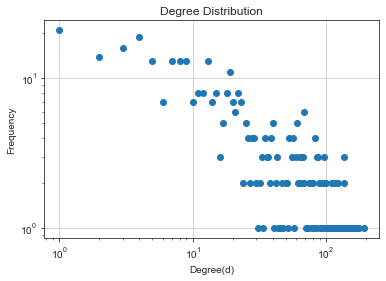

In [14]:
plot.degree_distribution(f'data{sep}last.gexf')
plt.savefig('last_degree_distribution.pdf',bbox_inches='tight')

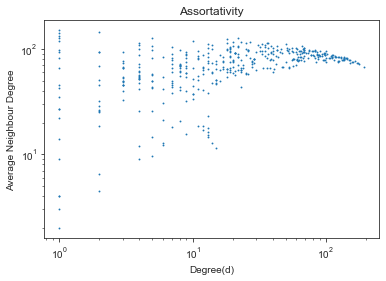

<Figure size 432x288 with 0 Axes>

In [15]:
plot.assortativity(f'data{sep}last.gexf')
plt.savefig('last_assort_distribution.pdf',bbox_inches='tight')

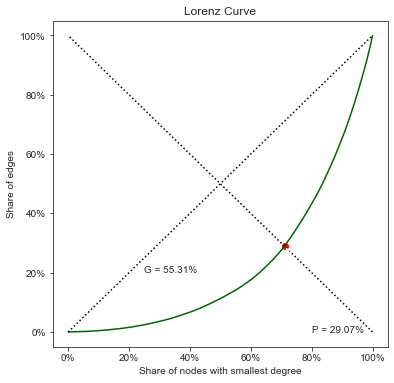

In [16]:
plot.lorenz_curve(f'data{sep}last.gexf')
plt.savefig('last_gini_distribution.pdf',bbox_inches='tight')

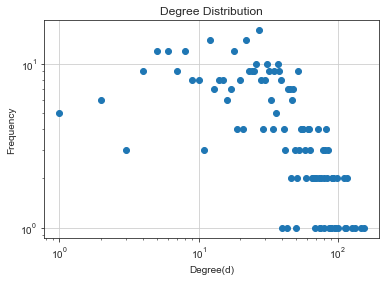

In [17]:
plot.degree_distribution(f'data{sep}spotify.gexf') 
plt.savefig('spotify_degree_distribution.pdf',bbox_inches='tight')

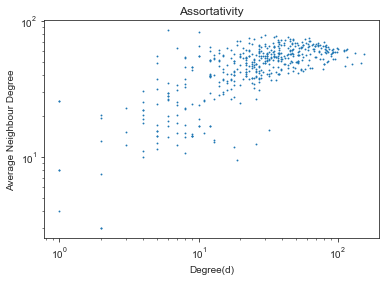

<Figure size 432x288 with 0 Axes>

In [18]:
plot.assortativity(f'data{sep}spotify.gexf')
plt.savefig('spotify_assort_distribution.pdf',bbox_inches='tight')

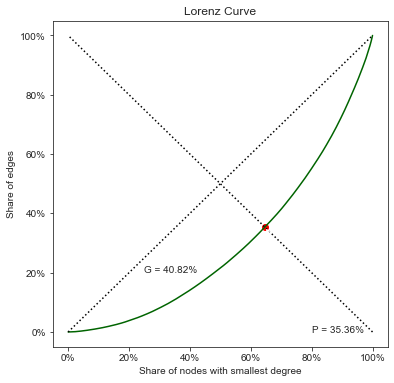

In [19]:
plot.lorenz_curve(f'data{sep}spotify.gexf')
plt.savefig('spotify_gini_distribution.pdf',bbox_inches='tight')

In [20]:
print("Average shortest path length of spotify network: {:.2f}".format(nx.average_shortest_path_length(spotify)))

print("Average shortest path length of last.fm network: {:.2f}".format(nx.average_shortest_path_length(last)))

Average shortest path length of spotify network: 2.55
Average shortest path length of last.fm network: 2.43


### Local network analysis

In [21]:
last_electronica_edges = last_edges[last_edges['genre_1']=='electronica']
last_electronica_edges = last_electronica_edges[last_electronica_edges['cosine_distance']>last_threshold]
last_electronica_edges = last_electronica_edges.sort_values(by=['cosine_distance'],ascending=False)

electronica_list = []
for i in range(len(last_electronica_edges)):
    electronica_list.extend([[last_electronica_edges.iloc[i,0],last_electronica_edges.iloc[i,1]]])
last_electronica_edges['tag_list'] = electronica_list

electronica_partner_genre = []
for i in range(len(last_electronica_edges)):
    item = list(last_electronica_edges['tag_list'])[i]
    for j in range(len(item)):
        if item[j] != 'electronica':
            electronica_partner_genre.append(item[j])
last_electronica_edges['partner_genre'] = electronica_partner_genre

last_electronica_partner_genre = last_electronica_edges[['cosine_distance','partner_genre']].reset_index(drop=True)
last_electronica_partner_genre['cosine_distance'] = last_electronica_partner_genre['cosine_distance']*150
# last_electronica_partner_genre = last_electronica_partner_genre.iloc[:50,:]

#######################################################

last_hiphop_1 = last_edges[last_edges['genre_1']=='hiphop']
last_hiphop_1 = last_hiphop_1[last_hiphop_1['cosine_distance']>last_threshold]
last_hiphop_2 = last_edges[last_edges['genre_2']=='hiphop']
last_hiphop_2 = last_hiphop_2[last_hiphop_2['cosine_distance']>last_threshold]
last_hiphop_edges = last_hiphop_1.append(last_hiphop_2)
last_hiphop_edges = last_hiphop_edges.sort_values(by=['cosine_distance'],ascending=False)
last_hiphop_nodes = list(last_hiphop_edges['genre_2'].unique())
last_hiphop_nodes = last_hiphop_nodes + list(last_hiphop_edges['genre_1'].unique())

hiphop_list = []
for i in range(len(last_hiphop_edges)):
    hiphop_list.extend([[last_hiphop_edges.iloc[i,0],last_hiphop_edges.iloc[i,1]]])
last_hiphop_edges['tag_list'] = hiphop_list

hiphop_partner_genre = []
for i in range(len(last_hiphop_edges)):
    item = list(last_hiphop_edges['tag_list'])[i]
    for j in range(len(item)):
        if item[j] != 'hiphop':
            hiphop_partner_genre.append(item[j])
last_hiphop_edges['partner_genre'] = hiphop_partner_genre

last_hiphop_partner_genre = last_hiphop_edges[['cosine_distance','partner_genre']].reset_index(drop=True)
last_hiphop_partner_genre['cosine_distance'] = last_hiphop_partner_genre['cosine_distance']*150

In [22]:
last_electro = ['experimental','ambient','dance','triphop','chillout',
           'industrial','synthpop', 'downtempo','psychedelic',
           'newwave','electro','techno','house','idm','french',
           'noise','trance', 'electropop', 'dubstep', 'lofi',  'minimal',
           'drumandbass', 'dub', 'psychedelicrock', 'darkambient', 'disco', 
           'lounge', 'glitch', 'ebm','industrialmetal', 'progressive', '8bit',
           'electroclash', 'breakbeat', 'nujazz', 'acidjazz', 'indietronica', 
           'newrave', 'breakcore', 'mellow', 'industrialrock', 'chiptune', 'chillwave',
           'psytrance', 'synth', 'drumnbass',  'deephouse', 'darkelectro', 'dumnbass',
           'grime', 'minimaltechno', 'progressivehouse', 'ninjatune', 'turntablism', 
           'beats', 'electrohouse', 'progressivetrance', 'jungle', 'futurepop', 'techhouse']

last_electro_other = ['alternative','indie','rock','pop','instrumental', 'folk',
         'hiphop', 'alternativerock', 'jazz', 'femalevocalists',
         'indierock', 'postrock', 'punk', 'british', 'singersongwriter',
         'indiepop', 'classicrock', 'progressiverock', 'soundtrack',
         'metal', 'postpunk', 'soul', 'acoustic', 'funk', '80s',
         'hardrock', 'classical', 'britpop', 'hardcore', 'rap',
         'punkrock', 'piano', 'blues', 'shoegaze', 'reggae', 'grunge',
         'avantgarde', 'swedish', 'japanese', 'progressivemetal', '90s',
         'posthardcore', 'dreampop', 'heavymetal', 'metalcore', 'emo',
         'r&b', 'poprock', 'german', 'darkwave', 'gothic', '60s', 'drone',
         'deathmetal', 'numetal', 'blackmetal', 'canadian', 'doommetal',
         'russian', '70s', 'ska', 'screamo', 'thrashmetal', 'country',
         'atmospheric', 'poppunk', 'worldmusic', 'garagerock', 'noiserock',
         'newage', 'mathrock', 'stonerrock', 'alternativemetal', 'gothicmetal',
         'melodicdeathmetal', 'sludge', 'australian', 'folkrock', 'guitar',
         'grindcore', 'ethereal', 'american', 'gothicrock', 'symphonicmetal',
         'icelandic', 'malevocalists', 'bluesrock', 'fusion', 'femalevocalist',
         'latin', 'artrock', 'folkmetal', 'norwegian', 'powermetal', 'polish',
         'comedy', 'finnish', 'jrock', 'krautrock', 'rapcore', 'jpop', 'spanish',
         'powerpop', 'undergroundhiphop', 'oldies', 'postmetal', 'contemporaryclassical',
         'irish', 'spacerock', 'glamrock', 'neofolk', 'goth', 'deathcore', 'mathcore',
         'indiefolk', 'classic', 'altcountry', 'bossanova', 'softrock', 'neoclassical',
         'rocknroll', 'experimentalrock', 'bigbeat', 'instrumentalhiphop', 'hardcorepunk',
         'swing', 'italian', 'romantic', 'emocore', 'twee', '00s', 'freakfolk']

In [23]:
last_hiphop = ['rap','r&b','undergroundhiphop','instrumentalhiphop','grime',
               'rapcore','gangstarap','abstracthiphop','undergroundrap',
               'cloudrap','oldschool','alternativehiphop','jazzhop','triphop']

last_hiphop_other = ['electronica','rock','pop','alternative','jazz',
                     'soul','indie','experimental','funk','punk',
                     'dance','folk','ambient','reggae',
                     'instrumental','alternativerock','indierock',
                     'chillout','femalevocalists','house','hardcore',
                     'singersongwriter','metal','british','downtempo',
                     'dubstep','classicrock','indiepop','techno',
                     'acoustic','punkrock','electro','punkrock','blues',
                     'postrock','blues','soundtrack','hardrock','newwave',
                     'industrial','dub','psychedelic','idm','drumandbass',
                     '80s','postpunk','progressiverock','french','grunge',
                     'ska','trap','emo','lofi','metalcore','trance','classical',
                     'posthardcore','synthpop','britpop','noise','poprock',
                     'numetal','japanese','electropop','shoegaze','90s',
                     'country','heavymetal','piano','disco','screamo',
                     'minimal','canadian','swedish','progressivemetal',
                     'deathmetal','turntablism','grindcore','dancehall',
                     'blackmetal','german','breakbeat','avantgarde',
                     '60s','glitch','thrashmetal','latin','noiserock',
                     'comedy','underground','70s','beats','russian','psychedelicrock',
                     'lounge','stonerrock','garagerock','nujazz','acidjazz',
                     'alternativemetal','mathrock','drone','australian','hardcorepunk',
                     'slude','dreampop','doommetal','jungle','malevocalists',
                     'ninjatune','breakcore','worldmusic','neosoul','american',
                     'mathcore','mashup','deathcore','drumnbass','8bit',
                     'industrialmetal','jpop']

In [24]:
last_hiphop_category_list = []
for i in last_hiphop_partner_genre['partner_genre']:
    if i in last_hiphop:
        last_hiphop_category_list.append('blue')
    else:
        last_hiphop_category_list.append('cyan')

last_hiphop_partner_genre['category'] = last_hiphop_category_list

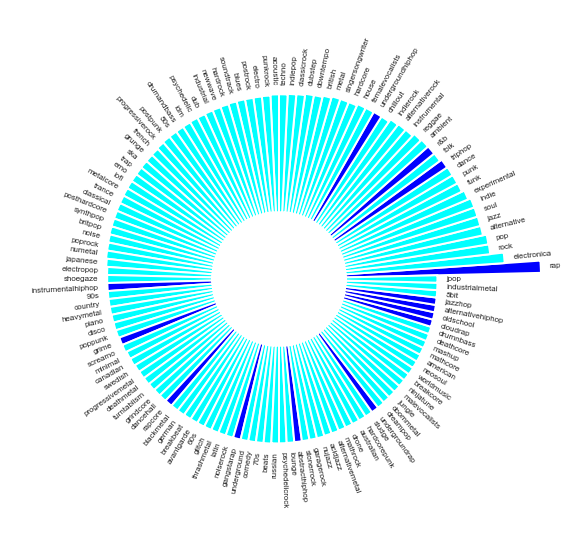

In [25]:
# Reorder the dataframe
df = last_hiphop_partner_genre

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 30
labelPadding = 4

# Compute max and min in the dataset
max = df['cosine_distance'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df.cosine_distance + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color=last_hiphop_category_list,
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["partner_genre"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",
        fontsize=8) 
    
plt.savefig('last_hiphop.pdf',bbox_inches='tight')

In [26]:
last_electronica_category_list = []
for i in last_electronica_partner_genre['partner_genre']:
    if i in last_electro:
        last_electronica_category_list.append('blue')
    else:
        last_electronica_category_list.append('cyan')

last_electronica_partner_genre['category'] = last_electronica_category_list

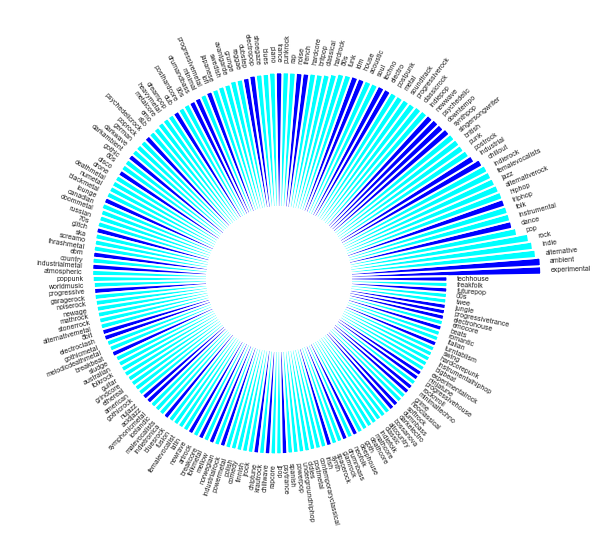

In [27]:
# Reorder the dataframe
df = last_electronica_partner_genre

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 30
labelPadding = 4

# Compute max and min in the dataset
max = df['cosine_distance'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df.cosine_distance + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color=last_electronica_category_list,
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["partner_genre"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",
        fontsize=7) 
    
plt.savefig('last_electronica.pdf',bbox_inches='tight')

In [28]:
spotify_threshold = 0

spotify_electronica_1 = spotify_edges[spotify_edges['genre_1']=='electronica']
spotify_electronica_1 = spotify_electronica_1[spotify_electronica_1['cosine_distance']>spotify_threshold]
spotify_electronica_2 = spotify_edges[spotify_edges['genre_2']=='electronica']
spotify_electronica_2 = spotify_electronica_2[spotify_electronica_2['cosine_distance']>spotify_threshold]
spotify_electronica_edges = spotify_electronica_1.append(spotify_electronica_2)
spotify_electronica_edges = spotify_electronica_edges.sort_values(by=['cosine_distance'],ascending=False)
spotify_electronica_nodes = list(spotify_electronica_edges['genre_2'].unique())
spotify_electronica_nodes = spotify_electronica_nodes + list(spotify_electronica_edges['genre_1'].unique())

electronica_list = []
for i in range(len(spotify_electronica_edges)):
    electronica_list.extend([[spotify_electronica_edges.iloc[i,0],spotify_electronica_edges.iloc[i,1]]])
spotify_electronica_edges['tag_list'] = electronica_list

electronica_partner_genre = []
for i in range(len(spotify_electronica_edges)):
    item = list(spotify_electronica_edges['tag_list'])[i]
    for j in range(len(item)):
        if item[j] != 'electronica':
            electronica_partner_genre.append(item[j])
spotify_electronica_edges['partner_genre'] = electronica_partner_genre

spotify_electronica_partner_genre = spotify_electronica_edges[['cosine_distance','partner_genre']].reset_index(drop=True)
spotify_electronica_partner_genre['cosine_distance'] = spotify_electronica_partner_genre['cosine_distance']*150
# spotify_electronica_partner_genre = spotify_electronica_partner_genre.iloc[:50,:]

#######################################################

spotify_hiphop_1 = spotify_edges[spotify_edges['genre_1']=='hip hop']
spotify_hiphop_1 = spotify_hiphop_1[spotify_hiphop_1['cosine_distance']>spotify_threshold]
spotify_hiphop_2 = spotify_edges[spotify_edges['genre_2']=='hip hop']
spotify_hiphop_2 = spotify_hiphop_2[spotify_hiphop_2['cosine_distance']>spotify_threshold]
spotify_hiphop_edges = spotify_hiphop_1.append(spotify_hiphop_2)
spotify_hiphop_edges = spotify_hiphop_edges.sort_values(by=['cosine_distance'],ascending=False)
spotify_hiphop_nodes = list(spotify_hiphop_edges['genre_2'].unique())
spotify_hiphop_nodes = spotify_hiphop_nodes + list(spotify_hiphop_edges['genre_1'].unique())

hiphop_list = []
for i in range(len(spotify_hiphop_edges)):
    hiphop_list.extend([[spotify_hiphop_edges.iloc[i,0],spotify_hiphop_edges.iloc[i,1]]])
spotify_hiphop_edges['tag_list'] = hiphop_list

hiphop_partner_genre = []
for i in range(len(spotify_hiphop_edges)):
    item = list(spotify_hiphop_edges['tag_list'])[i]
    for j in range(len(item)):
        if item[j] != 'hip hop':
            hiphop_partner_genre.append(item[j])
spotify_hiphop_edges['partner_genre'] = hiphop_partner_genre

spotify_hiphop_partner_genre = spotify_hiphop_edges[['cosine_distance','partner_genre']].reset_index(drop=True)
spotify_hiphop_partner_genre['cosine_distance'] = spotify_hiphop_partner_genre['cosine_distance']*150

In [29]:
spotify_electronica = ['trip hop','microhouse','intelligent dance music',
                       'alternative dance','downtempo','ninja','nu jazz',
                      'new rave','big beat','minimal techno','bass music',
                      'float house','wonky','chillwave','ambient','dance-punk',
                      'filter house','tech house','indietronica','chamber psych',
                      'outsider house','fourth world','deep house','experimental pop',
                      'german techno','nu disco','organic house','electropop','dream pop',
                      'compositional ambient','escape room','swedish electropop','electra'
                       'australian dance','metropopolis','new french touch','experimental',
                      'electro','tropical house','house','electro swing','vocal house',
                      'dance pop','future bass','neo-psychedelic','canadian electronic',
                      'deconstructed club','disco house','dance rock','electro house',
                      'modern funk','permanent wave','pop dance','new wave','chill out',
                      'progressive house']

spotify_electronica_other = ['art pop','indie soul','drone','indie jazz','freak folk',
                            'nu gaze','skimmer pop','modern rock','alternative hip hop',
                            'post-rock','art rock','shoegaze','melancholia','neo-classical',
                            'funk','hip hop','world','noise pop','british sould','hyperpop',
                            'new wave pop','la indie','soul','alternative rock','indie pop',
                            'uk hip hop','australian indie','champer pop','pop rock','indie folk',
                            'afropop','lilith','undergound hip hop','vapor soul','alternative r&b',
                            'modern alternative rock','rock']

In [30]:
spotify_hiphop = ['rap','gangster rap','hardcore hip hop','southern hip hop',
                 'east coast hip hop','pop rap','alternative hip hop','trap',
                 'conscious hip hop','underground hip hop','hip pop','dirty south rap','apl hip hop'
                 'r&b','urban contemporary','chicago rap','melodic rap','hip house',
                 'vapor trap','cali rap','trap queen','rap rock','trip hop','uk hip hop',
                 'chillhop','alternative r&b','pop r&b','indie r&b','neo r&b']

spotify_hiphop_other = ['new jack swing','dance pop','neo soul','electro','quiet storm',
                       'escape room','boy band','jazz boom bap',
                       'indie soul','pop','funk','big beat','electronica','soul','ninja',
                       'wonky','intelligent dance music','downtempo','canadian pop',
                       'nu jazz','la pop','pop dance','alternative rock']

In [31]:
spotify_hiphop_category_list = []
for i in spotify_hiphop_partner_genre['partner_genre']:
    if i in spotify_hiphop:
        spotify_hiphop_category_list.append('blue')
    else:
        spotify_hiphop_category_list.append('cyan')

spotify_hiphop_partner_genre['category'] = spotify_hiphop_category_list

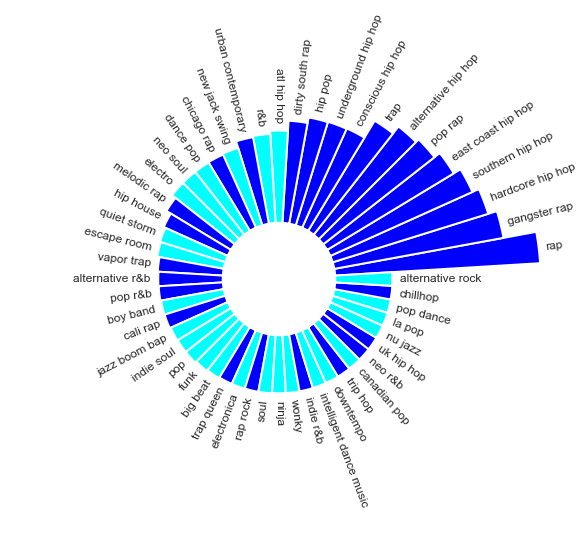

In [32]:
# Reorder the dataframe
df = spotify_hiphop_partner_genre

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 30
labelPadding = 4

# Compute max and min in the dataset
max = df['cosine_distance'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df.cosine_distance + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color=spotify_hiphop_category_list,
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["partner_genre"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",
        fontsize=12)
    
plt.savefig('spotify_hiphop.pdf',bbox_inches='tight')

In [33]:
spotify_electronica_category_list = []
for i in spotify_electronica_partner_genre['partner_genre']:
    if i in spotify_electronica:
        spotify_electronica_category_list.append('blue')
    else:
        spotify_electronica_category_list.append('cyan')

spotify_electronica_partner_genre['category'] = spotify_electronica_category_list

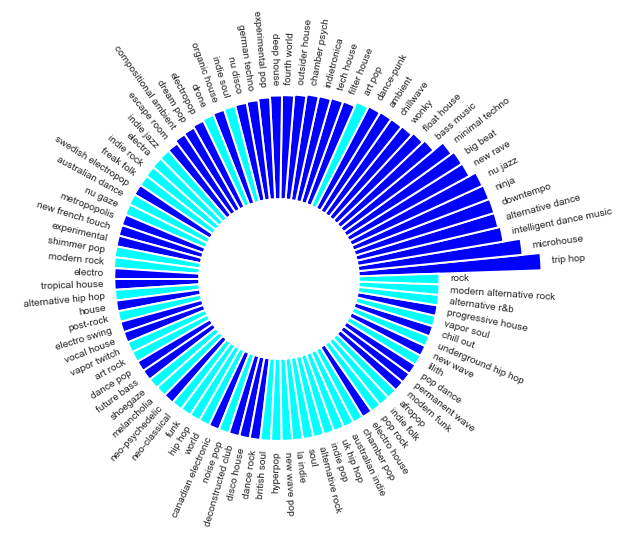

In [34]:
# Reorder the dataframe
df = spotify_electronica_partner_genre

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 30
labelPadding = 4

# Compute max and min in the dataset
max = df['cosine_distance'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df.cosine_distance + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color=spotify_electronica_category_list,
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df["partner_genre"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",
        fontsize=10)
    
plt.savefig('spotify_electronica.pdf',bbox_inches='tight')